In [3]:

import torch
from . import parameter

class MeanFunction(torch.nn.Module):
    """
    The base mean function class.
    To implement a mean function, write the __call__ method. This takes a
    tensor X and returns a tensor m(X). In accordance with the GPflow
    standard, each row of X represents one datum, and each row of Y is computed
    independently for each row of X.
    MeanFunction classes can have parameters, see the Linear class for an
    example.
    """
    def forward(self, X):
        raise NotImplementedError("Implement the forward method for this mean function")

    def __add__(self, other):
        return MeanAdditive(self, other)

    def __mul__(self, other):
        return MeanProduct(self, other)


class Zero(MeanFunction):
    def forward(self, X):
        return torch.zeros(X.size(0), 1, dtype=X.dtype, device=X.device)

class Linear(MeanFunction):
    """
    y_i = A x_i + b
    """
    def __init__(self, A=None, b=None):
        """
        A is a matrix which maps each element of X to Y, b is an additive
        constant.
        If X has N rows and D columns, and Y is intended to have Q columns,
        then A must be D x Q, b must be a vector of length Q.
        """
        A = torch.ones((1, 1)) if A is None else A
        b = torch.zeros(1) if b is None else b
        MeanFunction.__init__(self)
        if A.dim()==1:
            A = A.unsqueeze(1)
        self.A = parameter.Param(A)
        self.b = parameter.Param(b)

    def __call__(self, X):
        return torch.matmul(X, self.A.get()) + self.b.get()

ImportError: attempted relative import with no known parent package

In [4]:

import numpy
import abc
import torch

class ParamWithPrior(torch.nn.Parameter):
    @abc.abstractmethod
    def get(self):
        pass
    @abc.abstractmethod
    def log_jacobian_tensor(self):
        pass
    @abc.abstractstaticmethod
    def untransform(t, out=None):
        pass
    def __init__(self, val, prior=None, dtype=torch.float32):
        pass
    def __new__(cls, val, prior=None, dtype=torch.float32):
        if numpy.isscalar(val):
            val = torch.tensor([val], dtype=dtype)
        raw = cls.untransform(val)
        obj = super(ParamWithPrior, cls).__new__(cls, raw)
        obj.prior = prior
        return obj
    def set(self, t):
        if numpy.isscalar(t):
            t = torch.tensor(t, dtype=self.dtype)
        self.untransform(t, out=self)
    def get_prior(self):
        if self.prior is None:
            return 0.0
        
        log_jacobian = self.log_jacobian() #(unconstrained_tensor)
        logp_var = self.prior.logp(self.get())
        return log_jacobian+logp_var

class PositiveParam(ParamWithPrior): # log(1+exp(r))
    @staticmethod
    def untransform(t, out=None):
        with torch.no_grad():
            return torch.log(torch.exp(t) - 1, out=out)
    def get(self):
        return torch.log(1 + torch.exp(self))
    def log_jacobian(self):
        return -(torch.nn.functional.softplus(-self))

class Param(ParamWithPrior): # unconstrained / untransformed
    @staticmethod
    def untransform(t, out=None):
        if out is None:
            return t
        else:
            return out.copy_(t)
    def get(self):
        return self
    def log_jacobian(self):
        return torch.zeros((), dtype=self.dtype)  # dimension?


class LowerTriangularParam(ParamWithPrior):
    """
    A transform of the form
       tri_mat = vec_to_tri(x)
    x is a free variable, y is always a list of lower triangular matrices sized
    (N x N x D).
    """
    @staticmethod
    def untransform(t, out=None):
        ii,jj = numpy.tril_indices(t.size(0))
        return t[ii,jj]
    def get(self):
        numel = self.size(0)
        N = int((2*numel+0.25)**0.5-0.5)
        ii,jj = numpy.tril_indices(N)
        if self.dim()==2:
            mat = torch.zeros(N,N, self.size(1), dtype=self.dtype)
        else:
            mat = torch.zeros(N, N, dtype=self.dtype)
        mat[ii,jj] = self
        return mat
    def log_jacobian(self):
        return torch.zeros((), dtype=self.dtype)  # dimension?

In [6]:
# Copyright 2016 James Hensman, Mark van der Wilk, Valentine Svensson, alexggmatthews, fujiisoup
# Copyright 2017 Thomas Viehmann
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# import abc
import torch
import numpy



class GPModel(torch.nn.Module):
    """
    A base class for Gaussian process models, that is, those of the form
    .. math::
       :nowrap:
       \\begin{align}
       \\theta & \sim p(\\theta) \\\\
       f       & \sim \\mathcal{GP}(m(x), k(x, x'; \\theta)) \\\\
       f_i       & = f(x_i) \\\\
       y_i\,|\,f_i     & \sim p(y_i|f_i)
       \\end{align}
    This class mostly adds functionality to compile predictions. To use it,
    inheriting classes must define a build_predict function, which computes
    the means and variances of the latent function. This gets compiled
    similarly to build_likelihood in the Model class.
    These predictions are then pushed through the likelihood to obtain means
    and variances of held out data, self.predict_y.
    The predictions can also be used to compute the (log) density of held-out
    data via self.predict_density.
    For handling another data (Xnew, Ynew), set the new value to self.X and self.Y
    >>> m.X = Xnew
    >>> m.Y = Ynew
    """

    def __init__(self, X, Y, kern, likelihood, mean_function, name=None, jitter_level=1e-6):
        super(GPModel, self).__init__()
        self.name = name
        self.mean_function = mean_function or mean_functions.Zero()
        self.kern = kern
        self.likelihood = likelihood
        self.jitter_level = jitter_level

        if isinstance(X, numpy.ndarray):
            # X is a data matrix; each row represents one instance
            X = torch.from_numpy(X)
        if isinstance(Y, numpy.ndarray):
            # Y is a data matrix, rows correspond to the rows in X,
            # columns are treated independently
            Y = torch.from_numpy(Y)
        self.X, self.Y = X, Y

    # @abc.abstractmethod
    def compute_log_prior(self):
        """Compute the log prior of the model."""
        pass

    # @abc.abstractmethod
    def compute_log_likelihood(self, X=None, Y=None):
        """Compute the log likelihood of the model."""
        pass

    def objective(self, X=None, Y=None):
        pos_objective = self.compute_log_likelihood(X, Y)
        for param in self.parameters():
            if isinstance(param, parameter.ParamWithPrior):
                pos_objective = pos_objective + param.get_prior()
        return -pos_objective

    def forward(self, X=None, Y=None):
        return self.objective(X, Y)

    # @abc.abstractmethod
    def predict_f(self, Xnew, full_cov=False):
        """
        Compute the mean and variance of the latent function(s) at the points
        Xnew.
        """
        pass
        #return self._build_predict(Xnew) #    @autoflow((settings.tf_float, [None, None]))

    def predict_f_full_cov(self, Xnew):
        """
        Compute the mean and covariance matrix of the latent function(s) at the
        points Xnew.
        """
        return self.predict_f(Xnew, full_cov=True)

    def predict_f_samples(self, Xnew, num_samples):
        """
        Produce samples from the posterior latent function(s) at the points
        Xnew.
        """
        mu, var = self.predict_f(Xnew, full_cov=True)
        jitter = torch.eye(mu.size(0), dtype=mu.dtype,
                           device=mu.device) * self.jitter_level
        samples = []
        for i in range(self.num_latent):  # TV-Todo: batch??
            L = torch.cholesky(var[:, :, i] + jitter, upper=False)
            V = torch.randn(L.size(0), num_samples,
                            dtype=L.dtype, device=L.device)
            samples.append(mu[:, i:i + 1] + torch.matmul(L, V))
        return torch.stack(samples, dim=0)  # TV-Todo: transpose?

    def predict_y(self, Xnew):
        """
        Compute the mean and variance of held-out data at the points Xnew
        """
        pred_f_mean, pred_f_var = self.predict_f(Xnew)
        return self.likelihood.predict_mean_and_var(pred_f_mean, pred_f_var)

    def predict_density(self, Xnew, Ynew):
        """
        Compute the (log) density of the data Ynew at the points Xnew
        Note that this computes the log density of the data individually,
        ignoring correlations between them. The result is a matrix the same
        shape as Ynew containing the log densities.
        """
        pred_f_mean, pred_f_var = self.predict_f(Xnew)
        return self.likelihood.predict_density(pred_f_mean, pred_f_var, Ynew)


In [7]:
from torch.autograd import Variable


In [9]:
# Copyright 2016 Valentine Svensson, James Hensman, alexggmatthews
# Copyright 2017 Thomas Viehmann
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import torch
import numpy


def batch_tril(A):
    B = A.clone()
    ii, jj = numpy.triu_indices(B.size(-2), k=1, m=B.size(-1))
    B[..., ii, jj] = 0
    return B


def batch_diag(A):
    ii, jj = numpy.diag_indices(min(A.size(-2), A.size(-1)))
    return A[..., ii, jj]


def conditional(Xnew, X, kern, f, full_cov=False, q_sqrt=None, whiten=False, jitter_level=1e-6):
    """
    Given F, representing the GP at the points X, produce the mean and
    (co-)variance of the GP at the points Xnew.

    Additionally, there may be Gaussian uncertainty about F as represented by
    q_sqrt. In this case `f` represents the mean of the distribution and
    q_sqrt the square-root of the covariance.

    Additionally, the GP may have been centered (whitened) so that
        p(v) = N( 0, I)
        f = L v
    thus
        p(f) = N(0, LL^T) = N(0, K).
    In this case 'f' represents the values taken by v.

    The method can either return the diagonals of the covariance matrix for
    each output of the full covariance matrix (full_cov).

    We assume K independent GPs, represented by the columns of f (and the
    last dimension of q_sqrt).

    :param Xnew: data matrix, size N x D.
    :param X: data points, size M x D.
    :param kern: GPflow kernel.
    :param f: data matrix, M x K, representing the function values at X,
        for K functions.
    :param q_sqrt: matrix of standard-deviations or Cholesky matrices,
        size M x K or M x M x K.
    :param whiten: boolean of whether to whiten the representation as
        described above.

    :return: two element tuple with conditional mean and variance.
    """

    # compute kernel stuff
    num_data = X.size(0)  # M
    num_func = f.size(1)  # K
    Kmn = kern.K(X, Xnew)
    Kmm = kern.K(X) + torch.eye(num_data, dtype=X.dtype,
                                device=X.device) * jitter_level
    Lm = torch.cholesky(Kmm, upper=False)

    # Compute the projection matrix A
    A, _ = torch.solve(Kmn, Lm)

    # compute the covariance due to the conditioning
    if full_cov:
        fvar = kern.K(Xnew) - torch.matmul(A.t(), A)
        fvar = fvar.unsqueeze(0).expand(num_func, -1, -1)  # K x N x N
    else:
        fvar = kern.Kdiag(Xnew) - (A**2).sum(0)
        fvar = fvar.unsqueeze(0).expand(num_func, -1)  # K x N
    # fvar is K x N x N or K x N

    # another backsubstitution in the unwhitened case (complete the inverse of the cholesky decomposition)
    if not whiten:
        A, _ = torch.solve(A, Lm.t())

    # construct the conditional mean
    fmean = torch.matmul(A.t(), f)

    if q_sqrt is not None:
        if q_sqrt.dim() == 2:
            LTA = A * q_sqrt.t().unsqueeze(2)  # K x M x N
        elif q_sqrt.dim() == 3:
            L = batch_tril(q_sqrt.permute(2, 0, 1))  # K x M x M
            # A_tiled = tf.tile(tf.expand_dims(A, 0), tf.stack([num_func, 1, 1])) # I don't think I need this
            LTA = torch.matmul(L.transpose(-2, -1), A)  # K x M x N
        else:  # pragma: no cover
            raise ValueError(
                "Bad dimension for q_sqrt :{}".format(q_sqrt.dim()))
        if full_cov:
            fvar = fvar + torch.matmul(LTA.t(), LTA)  # K x N x N
        else:
            fvar = fvar + (LTA**2).sum(1)  # K x N
    fvar = fvar.permute(*range(fvar.dim()-1, -1, -1))  # N x K or N x N x K

    return fmean, fvar


In [10]:
# Copyright 2016 James Hensman, alexggmatthews
# Copyright 2017 Thomas Viehmann
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import torch
import numpy


def batch_tril(A):
    B = A.clone()
    ii, jj = numpy.triu_indices(B.size(-2), k=1, m=B.size(-1))
    B[..., ii, jj] = 0
    return B


def batch_diag(A):
    ii, jj = numpy.diag_indices(min(A.size(-2), A.size(-1)))
    return A[..., ii, jj]


def gauss_kl_white(q_mu, q_sqrt):
    """
    Compute the KL divergence from

          q(x) = N(q_mu, q_sqrt^2)
    to
          p(x) = N(0, I)

    We assume multiple independent distributions, given by the columns of
    q_mu and the last dimension of q_sqrt.

    q_mu is a matrix, each column contains a mean

    q_sqrt is a 3D tensor, each matrix within is a lower triangular square-root
        matrix of the covariance.
    """
    KL = 0.5 * (q_mu**2).sum()               # Mahalanobis term
    KL += -0.5 * numpy.prod(q_sqrt.size()[1:])  # constant term
    L = batch_tril(q_sqrt.permute(2, 0, 1))   # force lower triangle
    KL -= batch_diag(L).log().sum()          # logdet sum log(L**2)
    KL += 0.5 * (L**2).sum()                 # Trace term.
    return KL


def gauss_kl_white_diag(q_mu, q_sqrt):
    """
    Compute the KL divergence from

          q(x) = N(q_mu, q_sqrt^2)
    to
          p(x) = N(0, I)

    We assume multiple independent distributions, given by the columns of
    q_mu and q_sqrt

    q_mu is a matrix, each column contains a mean

    q_sqrt is a matrix, each column represents the diagonal of a square-root
        matrix of the covariance.
    """

    KL = 0.5 * (q_mu**2).sum()                    # Mahalanobis term
    KL += -0.5 * q_sqrt.numel()
    KL = KL - q_sqrt.abs().log().sum()            # Log-det of q-cov
    KL += 0.5 * (q_sqrt**2).sum()                 # Trace term
    return KL


def gauss_kl_diag(q_mu, q_sqrt, K):
    """
    Compute the KL divergence from

          q(x) = N(q_mu, q_sqrt^2)
    to
          p(x) = N(0, K)

    We assume multiple independent distributions, given by the columns of
    q_mu and q_sqrt.

    q_mu is a matrix, each column contains a mean

    q_sqrt is a matrix, each column represents the diagonal of a square-root
        matrix of the covariance of q.

    K is a positive definite matrix: the covariance of p.
    """
    L = torch.potrf(K, upper=False)
    alpha, _ = torch.gesv(q_mu, L)
    KL = 0.5 * (alpha**2).sum()                  # Mahalanobis term.
    num_latent = q_sqrt.size(1)
    KL += num_latent * torch.diag(L).log().sum()  # Prior log-det term.
    KL += -0.5 * q_sqrt.numel()                  # constant term
    KL += - q_sqrt.log().sum()                   # Log-det of q-cov
    K_inv, _ = torch.cholesky(
        torch.eye(L.size(0), dtype=L.dtype, device=L.device), L, upper=False)
    # Trace term.
    KL += 0.5 * (torch.diag(K_inv).unsqueeze(1) * q_sqrt**2).sum()
    return KL


def gauss_kl(q_mu, q_sqrt, K):
    """
    Compute the KL divergence from

          q(x) = N(q_mu, q_sqrt^2)
    to
          p(x) = N(0, K)

    We assume multiple independent distributions, given by the columns of
    q_mu and the last dimension of q_sqrt.

    q_mu is a matrix, each column contains a mean.

    q_sqrt is a 3D tensor, each matrix within is a lower triangular square-root
        matrix of the covariance of q.

    K is a positive definite matrix: the covariance of p.
    """
    L = torch.potrf(K, upper=False)
    alpha, _ = torch.gesv(q_mu, L)
    KL = 0.5 * (alpha**2).sum()                  # Mahalanobis term.
    num_latent = q_sqrt.size(2)
    KL += num_latent * torch.tiag(L).log().sum()  # Prior log-det term.
    KL += -0.5 * numpy.prod(q_sqrt.size()[1:])  # constant term
    Lq = batch_tril(q_sqrt.permute(2, 0, 1))  # force lower triangle
    KL += batch_diag(Lq).log().sum()         # logdet
    LiLq, _ = torch.gesv(Lq.view(-1, L.size(-1)),
                         L).view(*L.size())  # batch with same LHS
    KL += 0.5 * (LiLq**2).sum()  # Trace term
    return KL


In [13]:
class SVGP(GPModel):
    """
    This is the Sparse Variational GP (SVGP). The key reference is
    ::
      @inproceedings{hensman2014scalable,
        title={Scalable Variational Gaussian Process Classification},
        author={Hensman, James and Matthews,
                Alexander G. de G. and Ghahramani, Zoubin},
        booktitle={Proceedings of AISTATS},
        year={2015}
      }
    """

    def __init__(self, X, Y, kern, likelihood, Z,
                 mean_function=None,
                 num_latent=None,
                 q_diag=False,
                 whiten=True,
                 minibatch_size=None,
                 **kwargs):
        """
        - X is a data matrix, size N x D
        - Y is a data matrix, size N x R
        - kern, likelihood, mean_function are appropriate GPflow objects
        - Z is a matrix of pseudo inputs, size M x D
        - num_latent is the number of latent process to use, default to
          Y.shape[1]
        - q_diag is a boolean. If True, the covariance is approximated by a
          diagonal matrix.
        - whiten is a boolean. If True, we use the whitened representation of
          the inducing points.
        """
        # sort out the X, Y into MiniBatch objects if required.
        self.minibatch_size = minibatch_size

        # init the super class, accept args
        super(SVGP, self).__init__(X, Y, kern,
                                   likelihood, mean_function, **kwargs)
        self.num_data = X.size(0)
        self.q_diag, self.whiten = q_diag, whiten
        self.Z = parameter.Param(Z)
        self.num_latent = num_latent or Y.size(1)
        self.num_inducing = Z.size(0)

        # init variational parameters
        self.q_mu = parameter.Param(self.Z.data.new(
            self.num_inducing, self.num_latent).zero_())
        if self.q_diag:
            self.q_sqrt = parameter.PositiveParam(self.Z.data.new(
                self.num_inducing, self.num_latent).fill_(1.0))
        else:
            q_sqrt = torch.eye(self.num_inducing, out=self.Z.data.new()).unsqueeze(
                2).expand(-1, -1, self.num_latent)
            self.q_sqrt = parameter.LowerTriangularParam(
                q_sqrt)  # should the diagonal be all positive?

    def prior_KL(self):
        if self.whiten:
            if self.q_diag:
                KL = gauss_kl_white_diag(
                    self.q_mu.get(), self.q_sqrt.get())
            else:
                KL = gauss_kl_white(
                    self.q_mu.get(), self.q_sqrt.get())
        else:
            K = self.kern.K(self.Z.get()) + torch.eye(self.num_inducing,
                                                      out=self.Z.new()) * self.jitter_level
            if self.q_diag:
                KL = gauss_kl_diag(
                    self.q_mu.get(), self.q_sqrt.get(), K)
            else:
                KL = gauss_kl(
                    self.q_mu.get(), self.q_sqrt.get(), K)
        return KL

    def compute_log_likelihood(self, X=None, Y=None):
        """
        This gives a variational bound on the model likelihood.
        """

        if X is None:
            X = self.X
        if Y is None:
            Y = self.Y

        # Get prior KL.
        KL = self.prior_KL()

        # Get conditionals
        fmean, fvar = self.predict_f(X, full_cov=False)

        # Get variational expectations.
        var_exp = self.likelihood.variational_expectations(fmean, fvar, Y)

        # re-scale for minibatch size
        scale = float(self.num_data) / X.size(0)

        return var_exp.sum() * scale - KL

    def predict_f(self, Xnew, full_cov=False):
        mu, var = conditional(Xnew, self.Z.get(), self.kern, self.q_mu,
                                           q_sqrt=self.q_sqrt.get(), full_cov=full_cov, whiten=self.whiten,
                                           jitter_level=self.jitter_level)
        return mu + self.mean_function(Xnew), var


In [15]:
from matplotlib import pyplot
import torch
from torch.autograd import Variable
%matplotlib inline
pyplot.style.use('ggplot')
import IPython
import sys, os
import numpy
import time
sys.path.append(os.path.join(os.getcwd(),'..'))


In [18]:
# Copyright 2016 James Hensman, Valentine Svensson, alexggmatthews
# Copyright 2017 Thomas Viehmann
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch
import numpy

class Kern(torch.nn.Module):
    """
    The basic kernel class. Handles input_dim and active dims, and provides a
    generic '_slice' function to implement them.
    """

    def __init__(self, input_dim, active_dims=None, name=None):
        """
        input dim is an integer
        active dims is either an iterable of integers or None.

        Input dim is the number of input dimensions to the kernel. If the
        kernel is computed on a matrix X which has more columns than input_dim,
        then by default, only the first input_dim columns are used. If
        different columns are required, then they may be specified by
        active_dims.

        If active dims is None, it effectively defaults to range(input_dim),
        but we store it as a slice for efficiency.
        """
        super().__init__()
        self.name = name
        self.input_dim = int(input_dim)
        if active_dims is None:
            self.active_dims = slice(input_dim)
        elif isinstance(active_dims, slice):
            self.active_dims = active_dims
            if active_dims.start is not None and active_dims.stop is not None and active_dims.step is not None:
                assert len(range(*active_dims)) == input_dim  # pragma: no cover
        else:
            self.active_dims = numpy.array(active_dims, dtype=numpy.int32)
            assert len(active_dims) == input_dim

        self.num_gauss_hermite_points = 20

    def eKdiag(self, Xmu, Xcov):
        """
        Computes <K_xx>_q(x).
        :param Xmu: Mean (NxD)
        :param Xcov: Covariance (NxDxD or NxD)
        :return: (N)
        """
        self._check_quadrature()
        Xmu, _ = self._slice(Xmu, None)
        Xcov = self._slice_cov(Xcov)
        return mvnquad(lambda x: self.Kdiag(x, presliced=True),
                       Xmu, Xcov,
                       self.num_gauss_hermite_points, self.input_dim)  # N

    def eKxz(self, Z, Xmu, Xcov):
        """
        Computes <K_xz>_q(x) using quadrature.
        :param Z: Fixed inputs (MxD).
        :param Xmu: X means (NxD).
        :param Xcov: X covariances (NxDxD or NxD).
        :return: (NxM)
        """
        self._check_quadrature()
        Xmu, Z = self._slice(Xmu, Z)
        Xcov = self._slice_cov(Xcov)
        M = tf.shape(Z)[0]
        return mvnquad(lambda x: self.K(x, Z, presliced=True), Xmu, Xcov, self.num_gauss_hermite_points,
                       self.input_dim, Dout=(M,))  # (H**DxNxD, H**D)

    def exKxz(self, Z, Xmu, Xcov):
        """
        Computes <x_{t-1} K_{x_t z}>_q(x) for each pair of consecutive X's in
        Xmu & Xcov.
        :param Z: Fixed inputs (MxD).
        :param Xmu: X means (T+1xD).
        :param Xcov: 2xT+1xDxD. [0, t, :, :] contains covariances for x_t. [1, t, :, :] contains the cross covariances
        for t and t+1.
        :return: (TxMxD).
        """
        self._check_quadrature()
        # Slicing is NOT needed here. The desired behaviour is to *still* return an NxMxD matrix. As even when the
        # kernel does not depend on certain inputs, the output matrix will still contain the outer product between the
        # mean of x_{t-1} and K_{x_t Z}. The code here will do this correctly automatically, since the quadrature will
        # still be done over the distribution x_{t-1, t}, only now the kernel will not depend on certain inputs.
        # However, this does mean that at the time of running this function we need to know the input *size* of Xmu, not
        # just `input_dim`.
        M = tf.shape(Z)[0]
        D = self.input_size if hasattr(self, 'input_size') else self.input_dim  # Number of actual input dimensions
        assert Xmu.size(1)==D

        # First, transform the compact representation of Xmu and Xcov into a
        # list of full distributions.
        fXmu = tf.concat((Xmu[:-1, :], Xmu[1:, :]), 1)  # Nx2D
        fXcovt = tf.concat((Xcov[0, :-1, :, :], Xcov[1, :-1, :, :]), 2)  # NxDx2D
        fXcovb = tf.concat((tf.transpose(Xcov[1, :-1, :, :], (0, 2, 1)), Xcov[0, 1:, :, :]), 2)
        fXcov = tf.concat((fXcovt, fXcovb), 1)
        return mvnquad(lambda x: self.K(x[:, :D], Z).unsqueeze(2) *
                                 x[:, D:].unsqueeze(1),
                       fXmu, fXcov, self.num_gauss_hermite_points,
                       2 * D, Dout=(M, D))

    def eKzxKxz(self, Z, Xmu, Xcov):
        """
        Computes <K_zx Kxz>_q(x).
        :param Z: Fixed inputs MxD.
        :param Xmu: X means (NxD).
        :param Xcov: X covariances (NxDxD or NxD).
        :return: NxMxM
        """
        self._check_quadrature()
        Xmu, Z = self._slice(Xmu, Z)
        Xcov = self._slice_cov(Xcov)
        M = Z.size(0)

        def KzxKxz(x):
            Kxz = self.K(x, Z, presliced=True)
            return tf.expand_dims(Kxz, 2) * tf.expand_dims(Kxz, 1)

        return mvnquad(KzxKxz,
                       Xmu, Xcov, self.num_gauss_hermite_points,
                       self.input_dim, Dout=(M, M))

    def _check_quadrature(self):
        if settings.numerics.ekern_quadrature == "warn":
            warnings.warn("Using numerical quadrature for kernel expectation of %s. Use gpflow.ekernels instead." %
                          str(type(self)))
        if settings.numerics.ekern_quadrature == "error" or self.num_gauss_hermite_points == 0:
            raise RuntimeError("Settings indicate that quadrature may not be used.")

    def _slice(self, X, X2):
        """
        Slice the correct dimensions for use in the kernel, as indicated by
        `self.active_dims`.
        :param X: Input 1 (NxD).
        :param X2: Input 2 (MxD), may be None.
        :return: Sliced X, X2, (Nxself.input_dim).
        """
        #if isinstance(self.active_dims, slice):
        X = X[:, self.active_dims]
        if X2 is not None:
            X2 = X2[:, self.active_dims]
        # I think advanced indexing does the right thing also for the second case
        #else:
        assert X.size(1)==self.input_dim
        return X, X2

    def _slice_cov(self, cov):
        """
        Slice the correct dimensions for use in the kernel, as indicated by
        `self.active_dims` for covariance matrices. This requires slicing the
        rows *and* columns. This will also turn flattened diagonal
        matrices into a tensor of full diagonal matrices.
        :param cov: Tensor of covariance matrices (NxDxD or NxD).
        :return: N x self.input_dim x self.input_dim.
        """
        cov = tf.cond(tf.equal(tf.rank(cov), 2), lambda: tf.matrix_diag(cov), lambda: cov)

        if isinstance(self.active_dims, slice):
            cov = cov[..., self.active_dims, self.active_dims]
        else:
            cov_shape = cov.size()
            covr = cov.view(-1, cov_shape[-1], cov_shape[-1])
            gather1 = torch.gather(tf.transpose(covr, [2, 1, 0]), self.active_dims)
            gather2 = torch.gather(tf.transpose(gather1, [1, 0, 2]), self.active_dims)
            cov = tf.reshape(tf.transpose(gather2, [2, 0, 1]),
                             tf.concat([cov_shape[:-2], [len(self.active_dims), len(self.active_dims)]], 0))
        return cov

    def __add__(self, other):
        return Add([self, other])

    def __mul__(self, other):
        return Prod([self, other])


class Static(Kern):
    """
    Kernels that do not depend on the value of the inputs are 'Static'.  The only
    parameter is a variance.
    """

    def __init__(self, input_dim, variance=1.0, active_dims=None, name=None):
        super().__init__(input_dim, active_dims, name=name)
        self.variance = parameter.PositiveParam(variance)

    def Kdiag(self, X, presliced=False):
        return self.variance.get().expand(X.size(0))


class Linear(Kern):
    def __init__(self, input_dim, variance=1.0, active_dims=None, name=None):
        super().__init__(input_dim, active_dims, name=name)
        self.variance = parameter.PositiveParam(variance)

    def K(self, X, X2=None, presliced=False):
        if X2 is None:
            X2 = X
        return torch.mm(X * self.variance.get(), X2.t())

    def Kdiag(self, X, presliced=False):
        return ((X**2) * self.variance.get()).sum(1)


class White(Static):
    """
    The White kernel
    """

    def K(self, X, X2=None, presliced=False):
        if X2 is None:
            d = self.variance.get().expand(X.size(0))
            return torch.diag(d)
        else:
            return torch.zeros(X.size(0), X2.size(0), dtype=X.dtype, device=X.device)


class Constant(Static):
    """
    The Constant (aka Bias) kernel
    """

    def K(self, X, X2=None, presliced=False):
        if X2 is None:
            return self.variance.get().expand(X.size(0), X.size(0))
        else:
            return self.variance.get().expand(X.size(0), X2.size(0))

class Bias(Constant):
    """
    Another name for the Constant kernel, included for convenience.
    """
    pass


class Stationary(Kern):
    """
    Base class for kernels that are stationary, that is, they only depend on

        r = || x - x' ||

    This class handles 'ARD' behaviour, which stands for 'Automatic Relevance
    Determination'. This means that the kernel has one lengthscale per
    dimension, otherwise the kernel is isotropic (has a single lengthscale).
    """

    def __init__(self, input_dim, variance=1.0, lengthscales=None,
                 active_dims=None, ARD=False, name=None):
        """
        - input_dim is the dimension of the input to the kernel
        - variance is the (initial) value for the variance parameter
        - lengthscales is the initial value for the lengthscales parameter
          defaults to 1.0 (ARD=False) or np.ones(input_dim) (ARD=True).
        - active_dims is a list of length input_dim which controls which
          columns of X are used.
        - ARD specifies whether the kernel has one lengthscale per dimension
          (ARD=True) or a single lengthscale (ARD=False).
        """
        super(Stationary, self).__init__(input_dim, active_dims, name=name)
        self.variance = parameter.PositiveParam(variance)
        if ARD:
            if lengthscales is None:
                lengthscales = torch.ones(input_dim)
            else:
                # accepts float or array:
                lengthscales = lengthscales * torch.ones(input_dim)
            self.lengthscales = parameter.PositiveParam(lengthscales)
            self.ARD = True
        else:
            if lengthscales is None:
                lengthscales = 1.0
            self.lengthscales = parameter.PositiveParam(lengthscales)
            self.ARD = False

    def square_dist(self, X, X2):
        X = X / self.lengthscales.get()
        Xs = (X**2).sum(1)

        if X2 is None:
            dist = -2 * torch.matmul(X, X.t())
            dist += Xs.view(-1, 1) + Xs.view(1, -1)
            return dist

        X2 = X2 / self.lengthscales.get()
        X2s = (X2**2).sum(1)
        dist = -2 * torch.matmul(X, X2.t())
        dist += Xs.view(-1, 1) + X2s.view(1, -1)
        return dist


    def euclid_dist(self, X, X2):
        r2 = self.square_dist(X, X2)
        return (r2 + 1e-12)**0.5

    def Kdiag(self, X, presliced=False):
        return self.variance.get().expand(X.size(0))

class RBF(Stationary):
    """
    The radial basis function (RBF) or squared exponential kernel
    """

    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
        res = self.variance.get() * torch.exp(-0.5 * self.square_dist(X, X2))
        return res

class Exponential(Stationary):
    """
    The Exponential kernel
    """

    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
        r = self.euclid_dist(X, X2)
        return self.variance.get() * torch.exp(-0.5 * r)


class Matern12(Stationary):
    """
    The Matern 1/2 kernel
    """

    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
        r = self.euclid_dist(X, X2)
        return self.variance.get() * torch.exp(-r)


class Matern32(Stationary):
    """
    The Matern 3/2 kernel
    """

    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
        r = self.euclid_dist(X, X2)
        return self.variance.get() * (1. + (3.**0.5) * r) * torch.exp(-(3.**0.5) * r)


class Matern52(Stationary):
    """
    The Matern 5/2 kernel
    """

    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
        r = self.euclid_dist(X, X2)
        return self.variance.get() * (1.0 + (5.**0.5) * r + 5. / 3. * r**2) * torch.exp(-(5.**0.5) * r)


class Cosine(Stationary):
    """
    The Cosine kernel
    """

    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
        r = self.euclid_dist(X, X2)
        return self.variance.get() * torch.cos(r)


class ArcCosine(Kern):
    """
    The Arc-cosine family of kernels which mimics the computation in neural
    networks. The order parameter specifies the assumed activation function.
    The Multi Layer Perceptron (MLP) kernel is closely related to the ArcCosine
    kernel of order 0. The key reference is

    ::

        @incollection{NIPS2009_3628,
            title = {Kernel Methods for Deep Learning},
            author = {Youngmin Cho and Lawrence K. Saul},
            booktitle = {Advances in Neural Information Processing Systems 22},
            year = {2009},
            url = {http://papers.nips.cc/paper/3628-kernel-methods-for-deep-learning.pdf}
        }
    """

    implemented_orders = {0, 1, 2}
    def __init__(self, input_dim,
                 order=0,
                 variance=1.0, weight_variances=1., bias_variance=1.,
                 active_dims=None, ARD=False, name=None):
        """
        - input_dim is the dimension of the input to the kernel
        - order specifies the activation function of the neural network
          the function is a rectified monomial of the chosen order.
        - variance is the initial value for the variance parameter
        - weight_variances is the initial value for the weight_variances parameter
          defaults to 1.0 (ARD=False) or np.ones(input_dim) (ARD=True).
        - bias_variance is the initial value for the bias_variance parameter
          defaults to 1.0.
        - active_dims is a list of length input_dim which controls which
          columns of X are used.
        - ARD specifies whether the kernel has one weight_variance per dimension
          (ARD=True) or a single weight_variance (ARD=False).
        """
        super(ArcCosine, self).__init__(input_dim, active_dims, name=name)

        if order not in self.implemented_orders:
            raise ValueError('Requested kernel order is not implemented.')
        self.order = order

        self.variance = parameter.PositiveParam(variance)
        self.bias_variance = parameter.PositiveParam(variance)
        self.ARD = ARD
        if ARD:
            if weight_variances is None:
                weight_variances = self.variance.data.new(input_dim).fill_(1.0)
            else:
                # accepts float or Tensor:
                weight_variances = weight_variances * self.variance.data.new(input_dim).fill_(1.0)
            self.weight_variances = parameter.PositiveParam(weight_variances)
        else:
            if weight_variances is None:
                weight_variances = 1.0
            self.weight_variances = parameter.PositiveParam(weight_variances)

    def _weighted_product(self, X, X2=None):
        if X2 is None:
            return (self.weight_variances.get() * (X**2)).sum(1) + self.bias_variance.get()
        return torch.matmul(self.weight_variances.get() * X, X2.t()) + self.bias_variance.get()

    def _J(self, theta):
        """
        Implements the order dependent family of functions defined in equations
        4 to 7 in the reference paper.
        """
        if self.order == 0:
            return float(numpy.pi) - theta
        elif self.order == 1:
            return torch.sin(theta) + (float(numpy.pi) - theta) * torch.cos(theta)
        elif self.order == 2:
            return 3. * torch.sin(theta) * torch.cos(theta) + (float(numpy.pi) - theta) * (1. + 2. * torch.cos(theta) ** 2)

    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)

        X_denominator = self._weighted_product(X)**0.5
        if X2 is None:
            X2 = X
            X2_denominator = X_denominator
        else:
            X2_denominator = self._weighted_product(X2)**0.5

        numerator = self._weighted_product(X, X2)
        cos_theta = numerator / X_denominator[:, None] / X2_denominator[None, :]
        jitter = 1e-15
        theta = torch.acos(jitter + (1 - 2 * jitter) * cos_theta)

        return ( self.variance.get() * (1. / float(numpy.pi)) * self._J(theta)
                *X_denominator[:, None] ** self.order
                *X2_denominator[None, :] ** self.order)

    def Kdiag(self, X, presliced=False):
        if not presliced:
            X, _ = self._slice(X, None)

        X_product = self._weighted_product(X)
        theta = 0
        return self.variance.get() * (1. / float(numpy.pi)) * self._J(theta) * X_product ** self.order


class Combination(Kern):
    """
    Combine  a list of kernels, e.g. by adding or multiplying (see inheriting
    classes).

    The names of the kernels to be combined are generated from their class
    names.
    """

    def __init__(self, kern_list, name=None):
        for k in kern_list:
            assert isinstance(k, Kern), "can only add/multiply Kern instances"

        input_dim = numpy.max([k.input_dim if type(k.active_dims) is slice else numpy.max(k.active_dims) + 1 for k in kern_list])
        super(Combination, self).__init__(input_dim=input_dim, name=name)

        # add kernels to a list, flattening out instances of this class therein
        self.kern_list = torch.nn.ModuleList()
        for k in kern_list:
            if isinstance(k, self.__class__):
                self.kern_list.extend(k.kern_list)
            else:
                self.kern_list.append(k)

    @property
    def on_separate_dimensions(self):
        """
        Checks whether the kernels in the combination act on disjoint subsets
        of dimensions. Currently, it is hard to asses whether two slice objects
        will overlap, so this will always return False.
        :return: Boolean indicator.
        """
        if numpy.any([isinstance(k.active_dims, slice) for k in self.kern_list]):
            # Be conservative in the case of a slice object
            return False
        else:
            dimlist = [k.active_dims for k in self.kern_list]
            overlapping = False
            for i, dims_i in enumerate(dimlist):
                for dims_j in dimlist[i + 1:]:
                    if numpy.any(dims_i.reshape(-1, 1) == dims_j.reshape(1, -1)):
                        overlapping = True
            return not overlapping

        
class Add(Combination):
    def K(self, X, X2=None, presliced=False):
        res = 0.0
        for k in self.kern_list:
            res += k.K(X, X2, presliced=presliced)
        return res

    def Kdiag(self, X, presliced=False):
        res = 0.0
        for k in self.kern_list:
            res += k.Kdiag(X, presliced=presliced)
        return res


class Prod(Combination):
    def K(self, X, X2=None, presliced=False):
        res = 1.0
        for k in self.kern_list:
            res *= k.K(X, X2, presliced=presliced)
        return res

    def Kdiag(self, X, presliced=False):
        res = 1.0
        for k in self.kern_list:
            res *= k.Kdiag(X, presliced=presliced)
        return res


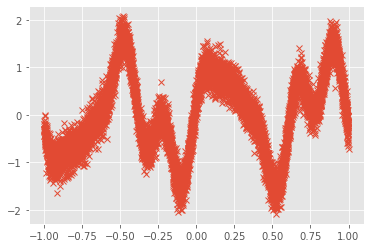

In [16]:
def func(x):
    return torch.sin(x * 3*3.14) + 0.3*torch.cos(x * 9*3.14) + 0.5 * torch.sin(x * 7*3.14)


X = torch.rand(10000, 1).double() * 2 - 1
Y = func(X) + torch.randn(10000, 1).double() * 0.2
pyplot.plot(X.numpy(), Y.numpy(), 'x')
D = X.size(1)
Xt = torch.linspace(-1.1, 1.1, 100).double().unsqueeze(1)
Yt = func(Xt)


In [19]:
# Copyright 2016 Valentine Svensson, James Hensman, alexggmatthews, Alexis Boukouvalas
# Copyright 2017 Artem Artemev @awav
# Copyright 2017 Thomas Viehmann
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy
import torch
from . import parameter
from . import quadrature
from . import densities

class Likelihood(torch.nn.Module):
    def __init__(self, name=None):
        super().__init__()
        self.name = name
        self.num_gauss_hermite_points = 20

    def predict_mean_and_var(self, Fmu, Fvar):
        """
        Given a Normal distribution for the latent function,
        return the mean of Y

        if
            q(f) = N(Fmu, Fvar)

        and this object represents

            p(y|f)

        then this method computes the predictive mean

           \int\int y p(y|f)q(f) df dy

        and the predictive variance

           \int\int y^2 p(y|f)q(f) df dy  - [ \int\int y^2 p(y|f)q(f) df dy ]^2

        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (e.g. Gaussian) will implement specific cases.
        """
        gh_x, gh_w = hermgauss(self.num_gauss_hermite_points)
        gh_w /= float(numpy.pi**0.5)
        gh_w = gh_w.reshape(-1, 1)
        shape = Fmu.size()
        Fmu = Fmu.view(-1,1)
        Fvar = Fvar.view(-1,1)
        X = gh_x[None, :] * (2.0 * Fvar)**0.5 + Fmu

        # here's the quadrature for the mean
        E_y = torch.matmul(self.conditional_mean(X), gh_w).view(shape)

        # here's the quadrature for the variance
        integrand = self.conditional_variance(X) + (self.conditional_mean(X))**2
        V_y = torch.matmul(integrand, gh_w).view(shape) - E_y**2

        return E_y, V_y

    def predict_density(self, Fmu, Fvar, Y):
        """
        Given a Normal distribution for the latent function, and a datum Y,
        compute the (log) predictive density of Y.

        i.e. if
            q(f) = N(Fmu, Fvar)

        and this object represents

            p(y|f)

        then this method computes the predictive density

           \int p(y=Y|f)q(f) df

        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (Gaussian, Poisson) will implement specific cases.
        """
        gh_x, gh_w = quadrature.hermgauss(self.num_gauss_hermite_points, dtype=Fmu.dtype)

        gh_w = gh_w.reshape(-1, 1) / float(numpy.sqrt(numpy.pi))
        shape = Fmu.size()
        Fmu, Fvar, Y = [e.view(-1, 1) for e in (Fmu, Fvar, Y)]
        X = gh_x * (2.0 * Fvar)**0.5 + Fmu
        Y = Y.expand(-1, self.num_gauss_hermite_points)  # broadcast Y to match X
        logp = self.logp(X, Y)
        return torch.matmul(logp.exp(), gh_w).view(*shape)

    def variational_expectations(self, Fmu, Fvar, Y):
        """
        Compute the expected log density of the data, given a Gaussian
        distribution for the function values.

        if
            q(f) = N(Fmu, Fvar)

        and this object represents

            p(y|f)

        then this method computes

           \int (\log p(y|f)) q(f) df.


        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (Gaussian, Poisson) will implement specific cases.
        """

        gh_x, gh_w = quadrature.hermgauss(self.num_gauss_hermite_points, dtype=Fmu.dtype)
        gh_x = gh_x.view(1, -1)
        gh_w = gh_w.view(-1, 1) / float(numpy.pi)**0.5
        shape = Fmu.size()
        Fmu, Fvar, Y = [e.view(-1, 1) for e in (Fmu, Fvar, Y)]
        X = gh_x * (2.0 * Fvar)**0.5 + Fmu
        Y = Y.expand(-1, self.num_gauss_hermite_points)  # broadcast Y to match X
        logp = self.logp(X, Y)
        return torch.matmul(logp, gh_w).view(*shape)

    def _check_targets(self, Y_np):  # pylint: disable=R0201
        """
        Check that the Y values are valid for the likelihood.
        Y_np is a numpy array.

        The base class check is that the array has two dimensions
        and consists only of floats. The float requirement is so that AutoFlow
        can work with Model.predict_density.
        """
        if not Y.dim() == 2:
            raise ValueError('targets must be shape N x D')
        #if np.array(list(Y_np)).dtype != settings.np_float:
        #    raise ValueError('use {}, even for discrete variables'.format(settings.np_float))


class Gaussian(Likelihood):
    def __init__(self, dtype=torch.float32):
        Likelihood.__init__(self)
        self.variance = parameter.PositiveParam(torch.tensor([1.0], dtype=dtype), dtype=dtype)

    def logp(self, F, Y):
        return densities.gaussian(F, Y, self.variance.get())

    def conditional_mean(self, F):
        return F

    def conditional_variance(self, F):
        return self.variance.get().expand_as(F)

    def predict_mean_and_var(self, Fmu, Fvar):
        return Fmu, Fvar + self.variance.get()

    def predict_density(self, Fmu, Fvar, Y):
        return densities.gaussian(Fmu, Y, Fvar + self.variance.get())

    def variational_expectations(self, Fmu, Fvar, Y):
        return (-0.5 * numpy.log(2 * numpy.pi) - 0.5 * torch.log(self.variance.get())
                - 0.5 * ((Y - Fmu)**2 + Fvar) / self.variance.get())


def probit(x):
    return 0.5 * (1.0 + torch.erf(x / (2.0**0.5))) * (1 - 2e-3) + 1e-3


class Bernoulli(Likelihood):
    def __init__(self, invlink=probit):
        super(Bernoulli, self).__init__()
        self.invlink = invlink

    def _check_targets(self, Y_np):
        super(Bernoulli, self)._check_targets(Y_np)
        Y_set = set(Y_np.flatten())
        if len(Y_set) > 2 or len(Y_set - set([1.])) > 1:
            raise Warning('all bernoulli variables should be in {1., k}, for some k')

    def logp(self, F, Y):
        return densities.bernoulli(self.invlink(F), Y)

    def predict_mean_and_var(self, Fmu, Fvar):
        if self.invlink is probit:
            p = probit(Fmu / (1 + Fvar)**0.5)
            return p, p - p**2
        else:
            # for other invlink, use quadrature
            return Likelihood.predict_mean_and_var(self, Fmu, Fvar)

    def predict_density(self, Fmu, Fvar, Y):
        p = self.predict_mean_and_var(Fmu, Fvar)[0]
        return densities.bernoulli(p, Y)

    def conditional_mean(self, F):
        return self.invlink(F)

    def conditional_variance(self, F):
        p = self.invlink(F)
        return p - p**2

    
class Exponential(Likelihood):
    def __init__(self, invlink=torch.exp):
        Likelihood.__init__(self)
        self.invlink = invlink

    def _check_targets(self, Y):
        super(Exponential, self)._check_targets(Y)
        if (Y < 0).any():
            raise ValueError('exponential variables must be positive')

    def logp(self, F, Y):
        return densities.exponential(self.invlink(F), Y)

    def conditional_mean(self, F):
        return self.invlink(F)

    def conditional_variance(self, F):
        return (self.invlink(F))**2

    def variational_expectations(self, Fmu, Fvar, Y):
        if self.invlink is torch.exp:
            return - torch.exp(-Fmu + Fvar / 2) * Y - Fmu
        return super(Exponential, self).variational_expectations(Fmu, Fvar, Y)

class RobustMax(object):
    """
    This class represent a multi-class inverse-link function. Given a vector
    f=[f_1, f_2, ... f_k], the result of the mapping is

    y = [y_1 ... y_k]

    with

    y_i = (1-eps)  i == argmax(f)
          eps/(k-1)  otherwise.


    """

    def __init__(self, num_classes, epsilon=1e-3):
        self.epsilon = epsilon
        self.num_classes = num_classes
        self._eps_K1 = self.epsilon / (self.num_classes - 1.)

    def __call__(self, F):
        _,i = torch.max(F.data, 1)
        one_hot = torch.full((F.size(0), self.num_classes), self._eps_K1, dtype=F.dtype, device=F.device).scatter_(1, i, 1 - self.epsilon)
        return one_hot

    def prob_is_largest(self, Y, mu, var, gh_x, gh_w):
        Y = Y.long()
        # work out what the mean and variance is of the indicated latent function.
        oh_on = torch.zeros(Y.numel(), self.num_classes, dtype=mu.dtype, device=mu.device).scatter_(1, Y.data, 1)
        mu_selected  = (oh_on * mu ).sum(1)
        var_selected = (oh_on * var).sum(1)

        # generate Gauss Hermite grid
        X = mu_selected.view(-1, 1) + gh_x * ((2. * var_selected).clamp(min=1e-10)**0.5).view(-1,1)

        # compute the CDF of the Gaussian between the latent functions and the grid (including the selected function)
        dist = (X.unsqueeze(1) - mu.unsqueeze(2)) / (var.clamp(min=1e-10)**0.5).unsqueeze(2)
        cdfs = 0.5 * (1.0 + torch.erf(dist / 2.0**0.5))

        cdfs = cdfs * (1 - 2e-4) + 1e-4

        # blank out all the distances on the selected latent function
        oh_off = torch.ones(Y.numel(), self.num_classes, dtype=mu.dtype, device=mu.device).scatter_(1,Y.data,0)
        cdfs = cdfs * oh_off.unsqueeze(2) + oh_on.unsqueeze(2)

        # take the product over the latent functions, and the sum over the GH grid.
        return torch.matmul(cdfs.prod(1), gh_w.view(-1,1) / (numpy.pi**0.5))


class MultiClass(Likelihood):
    def __init__(self, num_classes, invlink=None):
        """
        A likelihood that can do multi-way classification.
        Currently the only valid choice
        of inverse-link function (invlink) is an instance of RobustMax.
        """
        super(MultiClass, self).__init__()
        self.num_classes = num_classes
        if invlink is None:
            invlink = RobustMax(self.num_classes)
        elif not isinstance(invlink, RobustMax):
            raise NotImplementedError("Multiclass currently only supports RobustMax link")
        self.invlink = invlink

    def _check_targets(self, Y_np):
        super(MultiClass, self)._check_targets(Y_np)
        if not set(Y_np.view(-1)).issubset(set(range(self.num_classes))):
            raise ValueError('multiclass likelihood expects inputs to be in {0., 1., 2.,...,k-1}')
        if Y_np.size(1) != 1:
            raise ValueError('only one dimension currently supported for multiclass likelihood')

    def logp(self, F, Y):
        if isinstance(self.invlink, RobustMax):
            p = (torch.max(F, 1)[1].unsqueeze(1)==Y.long())*(1-self.invlink.epsilon-self.invlink._eps_K1)+self.invlink._eps_K1
            return torch.log(p)
        else:
            raise NotImplementedError("Multiclass currently only supports RobustMax link")

    def variational_expectations(self, Fmu, Fvar, Y):
        if isinstance(self.invlink, RobustMax):
            gh_x, gh_w = quadrature.hermgauss(self.num_gauss_hermite_points, dtype=Fmu.dtype)
            p = self.invlink.prob_is_largest(Y, Fmu, Fvar, gh_x, gh_w)
            return p * numpy.log(1 - self.invlink.epsilon) + (1. - p) * numpy.log(self.invlink._eps_K1)
        else:
            raise NotImplementedError("Multiclass currently only supports RobustMax link")

    def predict_mean_and_var(self, Fmu, Fvar):
        if isinstance(self.invlink, RobustMax):
            # To compute this, we'll compute the density for each possible output
            possible_outputs = [torch.full((Fmu.size(0), 1), i, dtype=torch.long, device=Fmu.device) for i in range(self.num_classes)]
            ps = [self._predict_non_logged_density(Fmu, Fvar, po) for po in possible_outputs]
            ps = torch.stack([p.view(-1) for p in ps],1)
            return ps, ps - ps**2
        else:
            raise NotImplementedError("Multiclass currently only supports RobustMax link")

    def predict_density(self, Fmu, Fvar, Y):
        return torch.log(self._predict_non_logged_density(Fmu, Fvar, Y))

    def _predict_non_logged_density(self, Fmu, Fvar, Y):
        if isinstance(self.invlink, RobustMax):
            gh_x, gh_w = quadrature.hermgauss(self.num_gauss_hermite_points, dtype=Fmu.dtype)
            p = self.invlink.prob_is_largest(Y, Fmu, Fvar, gh_x, gh_w)
            return p * (1 - self.invlink.epsilon) + (1. - p) * (self.invlink._eps_K1)
        else:
            raise NotImplementedError("Multiclass currently only supports RobustMax link")

    def conditional_mean(self, F):
        return self.invlink(F)

    def conditional_variance(self, F):
        p = self.conditional_mean(F)
        return p - p**2


ImportError: attempted relative import with no known parent package

In [ ]:
k = RBF(D,variance=torch.DoubleTensor([1.0])).double()
Z = X[:M].clone()
m = SVGP(Variable(X), Variable(Y.unsqueeze(1)),
                         likelihood=Gaussian(ttype=torch.DoubleTensor),
                         kern=k, Z=Z)
m